In [1]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Reading the input files
df = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DF - sorted.csv", header=None)
dss = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DSS - sorted.csv", header=None)
dhf = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DHF - sorted.csv", header=None)

# Making the disease label column
df_disease = [0] * len(df)
dss_disease = [1] * len(dss)
dhf_disease = [1] * len(dhf)

# Attaching the "Disease" label column to the input
df["Disease"] = df_disease
dss["Disease"] = dss_disease
dhf["Disease"] = dhf_disease

# Renaming the columns
df = df.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})
dss = dss.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})
dhf = dhf.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

# clearing the memory
del df_disease
del dss_disease
del dhf_disease

In [3]:
# Concatinating the input data into one DataFrame
result = pd.concat([df, dss, dhf], axis = 0, sort = False)
print("The combined shape of the given data is:", str(result.shape))

# Shuffling the data and then taking a peek
result = result.sample(frac = 1)

# clearing the memory
del df
del dhf
del dss

The combined shape of the given data is: (1347, 2)


In [4]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

result['words'] = result.apply(lambda x: getKmers(x['Sequence']), axis=1)
result = result.drop('Sequence', axis=1)

result_texts = list(result['words'])
for item in range(len(result_texts)):
    result_texts[item] = ' '.join(result_texts[item])

The shape of y is: (1347,)


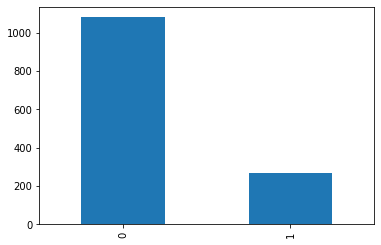

In [5]:
# Creating y and printing the shape of it
y = result.iloc[:, 0].values
print("The shape of y is:", y.shape)

# Checking the balance of the disease severity
result["Disease"].value_counts().sort_index().plot.bar()

# clearing the memory
del result

In [6]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(result_texts)

# clearing the memory
del cv

In [7]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

# clearing the memory
del x
del y

The shape of x_train is: (1077, 96366)
The shape of y_train is: (1077,)
The shape of x_test is: (270, 96366)
The shape of y_test is: (270,)


## Naive Bayes

In [8]:
# Multinomial Naive Bayes Classifier #
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
X_train = X_train.toarray()
classifier.fit(X_train, y_train)

# Making a prediction of the test set sequences
X_test = X_test.toarray()
y_pred = classifier.predict(X_test)

# clearing the memory
del X_train
del X_test
del classifier

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = {} \nprecision = {} \nrecall = {} \nf1 = {}".format(accuracy, precision, recall, f1))

# clearing the memory
del y_pred
del accuracy
del precision
del recall
del f1

Confusion matrix

Predicted    0   1
Actual            
0          213   9
1           16  32
accuracy = 0.9074074074074074 
precision = 0.9035277689021431 
recall = 0.9074074074074074 
f1 = 0.9044846934679764
